# Decision Tree
Decision trees are a supervised machine learning algorithm used for classification or regression. A tree-like model is constructed, where each internal node represents a feature or attribute, and each leaf node represents a prediction or outcome. The tree is built by recursively splitting the dataset based on the best attribute that maximizes information gain or minimizes impurity. When a prediction is needed, the input record traverses the tree from the root to a leaf, following the path determined by the attribute values, and the corresponding prediction is made based on the outcome associated with that leaf node.

### Import libraries

In [2]:
import pandas as pd
import numpy as np

### Read data from CSV

In [3]:
data = pd.read_csv("/kaggle/input/500-person-gender-height-weight-bodymassindex/500_Person_Gender_Height_Weight_Index.csv")
display(data)

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
...,...,...,...,...
495,Female,150,153,5
496,Female,184,121,4
497,Female,141,136,5
498,Male,150,95,5


In [4]:
data['obese'] = (data.Index >= 4).astype('int')
data.drop('Index', axis = 1, inplace = True)
display(data)

,Gender,Height,Weight,obese
0,Male,174,96,1
1,Male,189,87,0
2,Female,185,110,1
3,Female,195,104,0
4,Male,149,61,0
...,...,...,...,...
495,Female,150,153,1
496,Female,184,121,1
497,Female,141,136,1
498,Male,150,95,1


## Decision tree algorithm
A decision trees have many sub-trees, each enhacing the prediction of the previous node. This goes until we get to a node that does not split. This last node is known as a leaf node. 

For example:

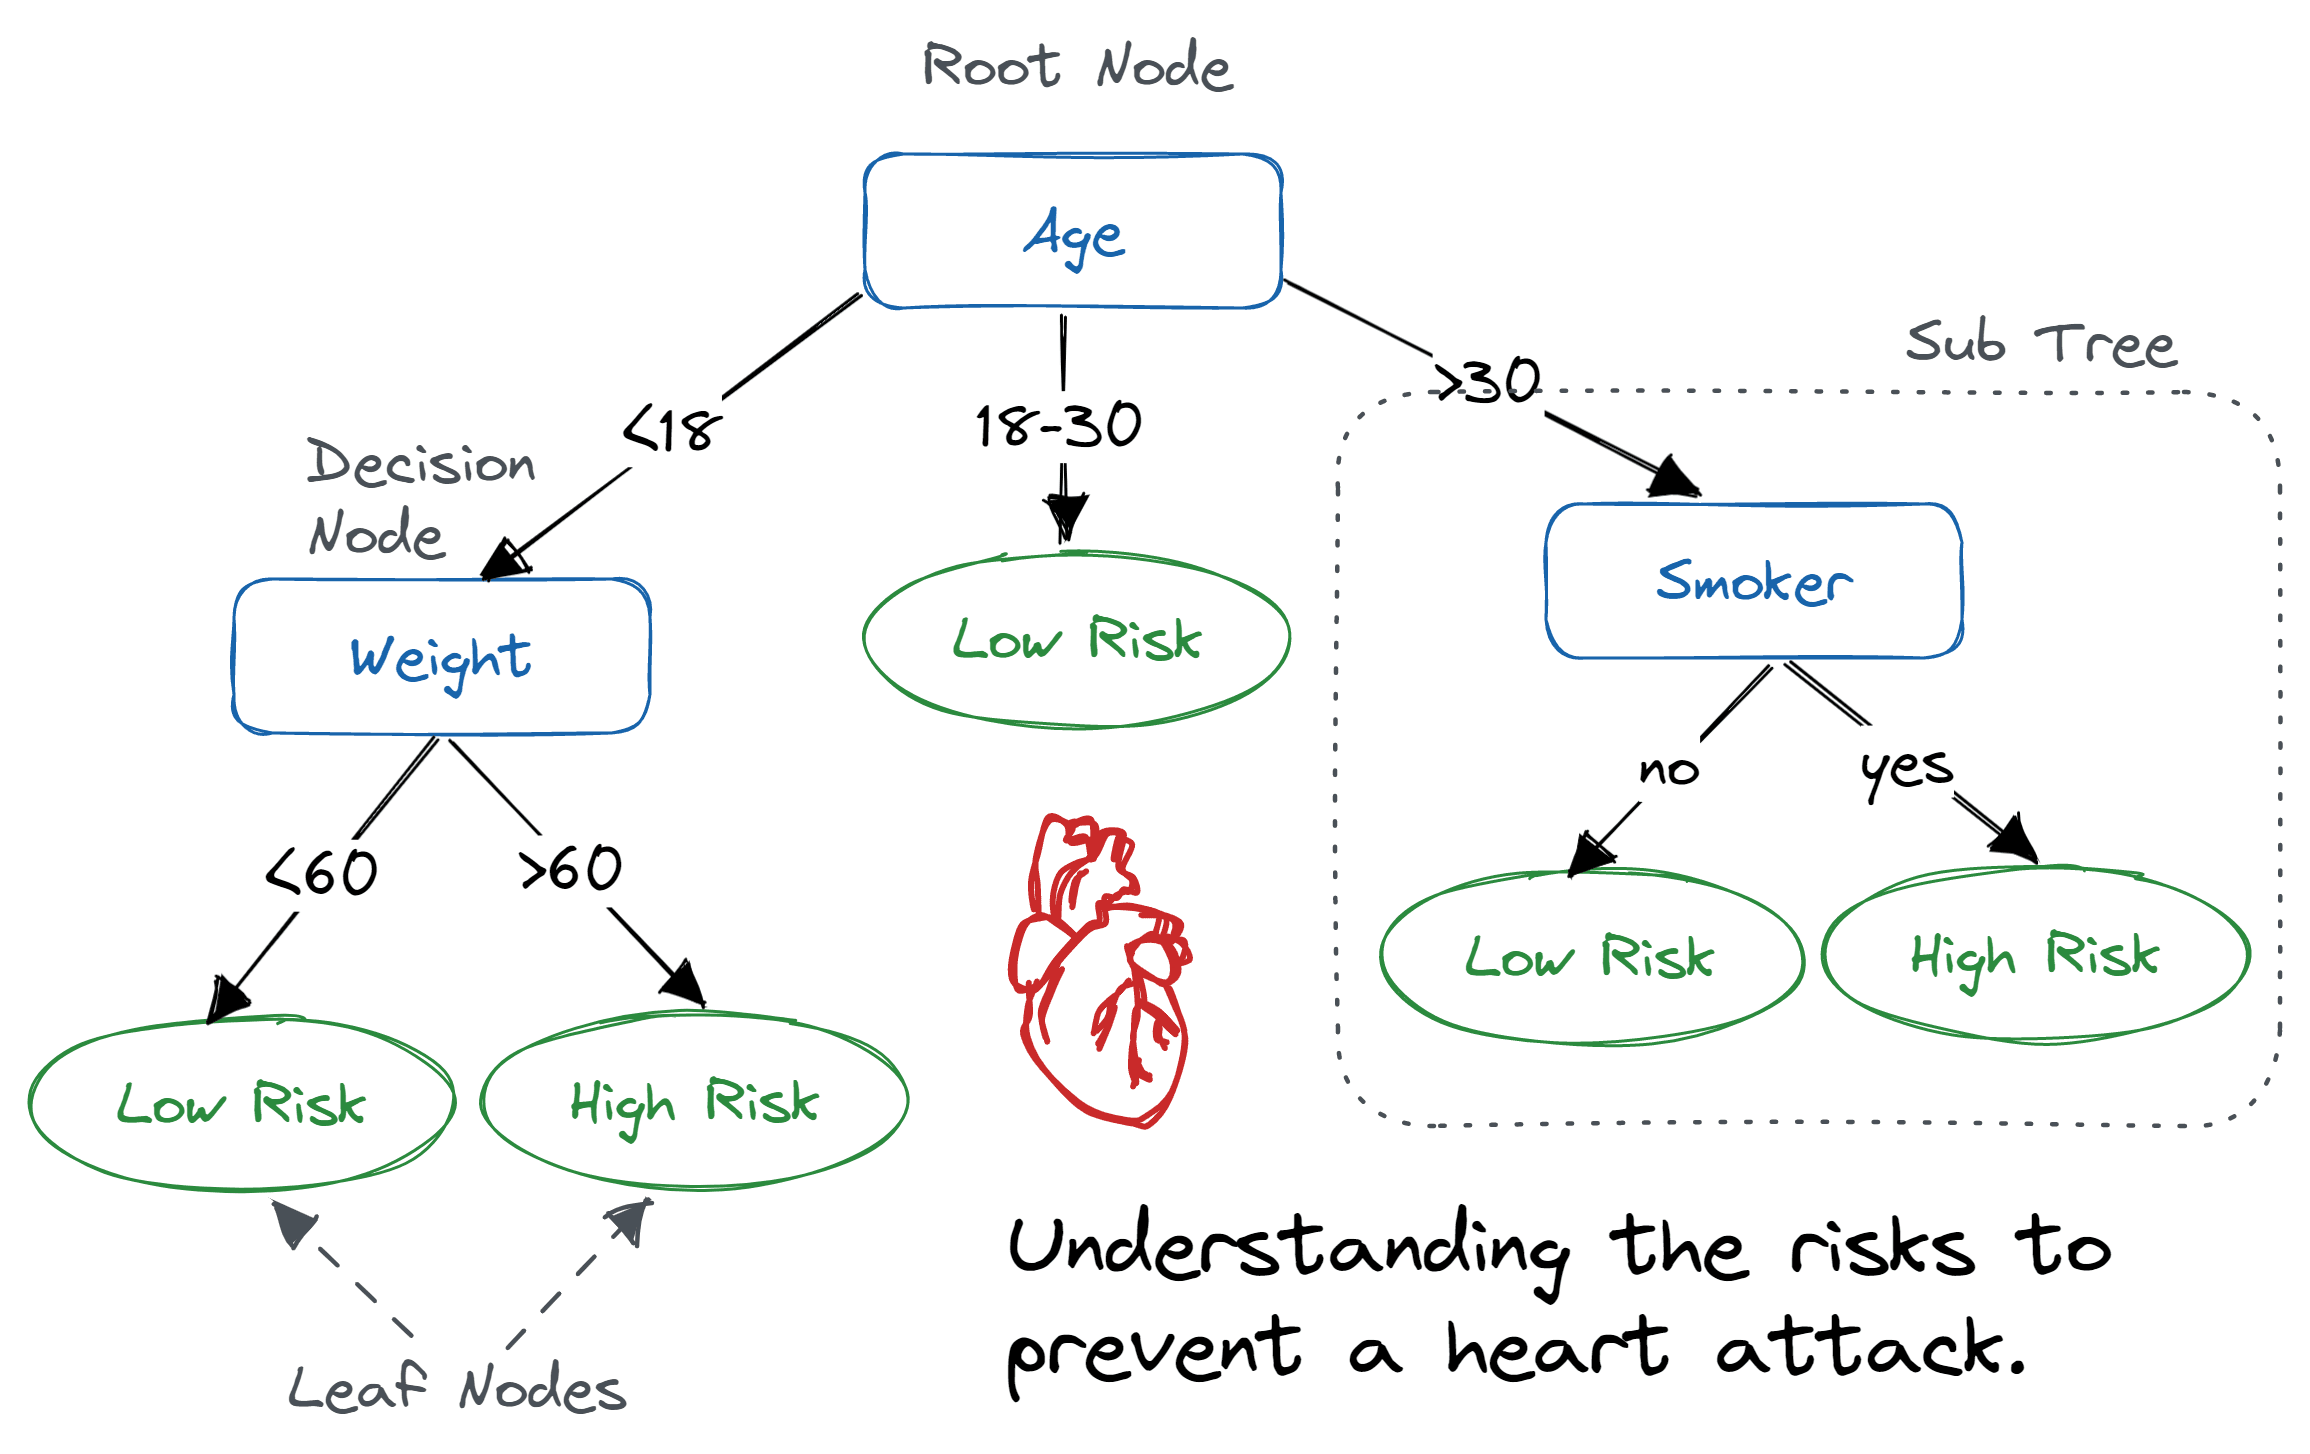

The decision tree algorithm's goal is to find the best variables and cutoff values for each decision node

### Cost function
"Impurty" means the likelyhood of an incorrect classification when a division is performed. The purpose of cost functions in this algorithm is to evaluate impurity. 

For example, lets make a random cut at weight=100kg. If we do so, there will be 82 miss classifications

In [5]:
#Count of misclassifications when cutting at 100kg:
print(data.loc[(data['Weight']>=100) & (data['obese']==0),:].shape[0])
print(data.loc[(data['Weight']<100) & (data['obese']==1),:].shape[0])
print("Count of misclassifications:",18+64)

18
64
Count of misclassifications: 82


If we cut at weight=80kg, there will be only 78 misclassifications. Therefore, this cut is better.

In [6]:
#Count of misclassifications when cutting at 80kg:
print(data.loc[(data['Weight']>=80) & (data['obese']==0),:].shape[0])
print(data.loc[(data['Weight']<80) & (data['obese']==1),:].shape[0])
print("Count of misclassifications:",63+15)

63
15
Count of misclassifications: 78


### Gini index
The Gini index is a popular cost function in decision trees. It measures the probability of misclassifying a chosen characteristic.
It ranges from 0 (a pure cut) to 0.5 (a completely impure cut that divides the data equally). The Gini index is calculated as follows:

$$
Gini = 1 - \sum_{i=1}^{n} (P_i)^2
 $$
 
Where P<sub>i</sub> is the probability of having that class or value.



In [7]:
def gini_impurity(y):
  '''
  Given a Pandas Series, it calculates the Gini Impurity. 
  y: variable with which calculate Gini Impurity.
  '''
  if isinstance(y, pd.Series):
    p = y.value_counts()/y.shape[0]
    gini = 1-np.sum(p**2)
    return(gini)

  else:
    raise('Object must be a Pandas Series.')

gini_impurity(data.Gender) 

0.4998

### Entropy
Another way to measure impurity is entropy. Unlike the Gini index, whose range goes from 0 to 0.5, the entropy range is different, since it goes from 0 to 1. In this way, values close to zero are less impure than those that approach 1
$$ S = -\sum p(x) \log_2 p(x)$$


In [8]:
def entropy(y):
  '''
  Given a Pandas Series, it calculates the entropy. 
  y: variable with which calculate entropy.
  '''
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)

  else:
    raise('Object must be a Pandas Series.')

entropy(data.Gender)  


0.9997114388674198

### Information Gain
As we have seen, cuts are compared by impurity. Therefore, we are interested in comparing those cuts that generate less impurity. For this, information gain is used, which indicates the improvement when making different partitions and is usually used with entropy (it could also be used with the Gini index, although in that case it would not be called information gain).
$$ \text{Information Gain}(D, A) = \text{Entropy}(D) - \sum_{v \in \text{Values}(A)} \frac{|D_v|}{|D|} \times \text{Entropy}(D_v)
$$

In [9]:
def variance(y):
    if(len(y) == 1):
        return 0
    else:
        return y.var()

def information_gain(y, mask, func=entropy):
    a = sum(mask)
    b = mask.shape[0] - a

    if(a == 0 or b ==0): 
        ig = 0

    else:
        if y.dtypes != 'O':
            ig = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
        else:
              ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
    return ig


In [10]:
information_gain(data['obese'], data['Gender'] == 'Male')

-0.0002808244603315635

In [18]:
information_gain(data['obese'], data['Weight'] <100)

0.10145545873057096

### Making splits

1. Calculate the information gain for all variables.
2. Choose the split that generates the highest information gain as a split.
3. Repeat step 1 and 2

In [11]:
import itertools

def categorical_options(a):
  '''
  Creates all possible combinations from a Pandas Series.
  a: Pandas Series from where to get all possible combinations. 
  '''
  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):
  '''
  Given a predictor & target variable, returns the best split, the error and the type of variable based on a selected cost function.
  x: predictor variable as Pandas Series.
  y: target variable as Pandas Series.
  func: function to be used to calculate the best split.
  '''

  split_value = []
  ig = [] 

  numeric_variable = True if x.dtypes != 'O' else False

  # Create options according to variable type
  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else: 
    options = categorical_options(x)

  # Calculate ig for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_ig = information_gain(y, mask, func)
    # Append results
    ig.append(val_ig)
    split_value.append(val)

  # Check if there are more than 1 results if not, return False
  if len(ig) == 0:
    return(None,None,None, False)

  else:
  # Get results with highest IG
    best_ig = max(ig)
    best_ig_index = ig.index(best_ig)
    best_split = split_value[best_ig_index]
    return(best_ig,best_split,numeric_variable, True)


weight_ig, weight_slpit, _, _ = max_information_gain_split(data['Weight'], data['obese'],)  


print(
  "The best split for Weight is when the variable is less than ",
  weight_slpit,"\nInformation Gain for that split is:", weight_ig
)


The best split for Weight is when the variable is less than  103 
Information Gain for that split is: 0.10625190497954967


In [12]:
data.drop('obese', axis= 1).apply(max_information_gain_split, y = data['obese'])


,Gender,Height,Weight
0,-0.000281,0.019684,0.106252
1,[Male],174,103
2,False,True,True
3,True,True,True


As we can see, the variable with the highest Information Gain is Weight. Therefore, it will be the variable that we use first to do the split. In addition, we also have the value on which the split must be performed: 103.

### Determining the depth of the tree

To avoiding overfitting, we will use three ways to limit the tree depth:

- max_depth: maximum depth of the tree.
- min_samples_split: indicates the minimum number of observations a sheet must have to continue creating new nodes.
- min_information_gain: the minimum amount the information gain must increase for the tree to continue growing.


The three functions below are one that, given some data, returns the best split with its corresponding information, another that, given some data and a split, makes the split and returns the prediction and finally, a function that given some data, makes a prediction.



In [13]:
def get_best_split(y, data):
  '''
  Given a data, select the best split and return the variable, the value, the variable type and the information gain.
  y: name of the target variable
  data: dataframe where to find the best split.
  '''
  masks = data.drop(y, axis= 1).apply(max_information_gain_split, y = data[y])
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)
  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1] 
    split_ig = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_ig, split_numeric)


def make_split(variable, value, data, is_numeric):
  '''
  Given a data and a split conditions, do the split.
  variable: variable with which make the split.
  value: value of the variable to make the split.
  data: data to be splitted.
  is_numeric: boolean considering if the variable to be splitted is numeric or not.
  '''
  if is_numeric:
    data_1 = data[data[variable] < value]
    data_2 = data[(data[variable] < value) == False]

  else:
    data_1 = data[data[variable].isin(value)]
    data_2 = data[(data[variable].isin(value)) == False]

  return(data_1,data_2)

def make_prediction(data, target_factor):
  '''
  Given the target variable, make a prediction.
  data: pandas series for target variable
  target_factor: boolean considering if the variable is a factor or not
  '''

  # Make predictions
  if target_factor:
    pred = data.value_counts().idxmax()
  else:
    pred = data.mean()

  return pred


In [14]:
def train_tree(data, y, target_factor, max_depth=None, min_samples_split=None, min_information_gain=1e-20, counter=0, max_categories=20):
    '''
    Trains a Decision Tree
    data: Data to be used to train the Decision Tree
    y: target variable column name
    target_factor: boolean to consider if target variable is factor or numeric.
    max_depth: maximum depth to stop splitting.
    min_samples_split: minimum number of observations to make a split.
    min_information_gain: minimum ig gain to consider a split to be valid.
    max_categories: maximum number of different values accepted for categorical values. High number of values will slow down learning process. R
    '''

    # Check that max_categories is fulfilled
    if counter == 0:
        types = data.dtypes
        check_columns = types[types == "object"].index
        for column in check_columns:
            var_length = len(data[column].value_counts())
            if var_length > max_categories:
                raise ValueError('The variable ' + column + ' has ' + str(var_length) + ' unique values, which is more than the accepted ones: ' + str(max_categories))

    # Check for depth conditions
    if max_depth is None:
        depth_cond = True
    else:
        if counter < max_depth:
            depth_cond = True
        else:
            depth_cond = False

    # Check for sample conditions
    if min_samples_split is None:
        sample_cond = True
    else:
        if data.shape[0] > min_samples_split:
            sample_cond = True
        else:
            sample_cond = False

    # Check for ig condition
    if depth_cond and sample_cond:
        var, val, ig, var_type = get_best_split(y, data)

        # If ig condition is fulfilled, make split
        if ig is not None and ig >= min_information_gain:
            counter += 1
            left, right = make_split(var, val, data, var_type)

            # Instantiate sub-tree
            split_type = "<=" if var_type else "in"
            question = "{} {} {}".format(var, split_type, val)
            subtree = {question: []}

            # Find answers (recursion)
            yes_answer = train_tree(left, y, target_factor, max_depth, min_samples_split, min_information_gain, counter)
            no_answer = train_tree(right, y, target_factor, max_depth, min_samples_split, min_information_gain, counter)

            if yes_answer == no_answer:
                subtree = yes_answer
            else:
                subtree[question].append(yes_answer)
                subtree[question].append(no_answer)

        # If it doesn't match IG condition, make prediction
        else:
            pred = make_prediction(data[y], target_factor)
            return pred

    # Drop dataset if it doesn't match depth or sample conditions
    else:
        pred = make_prediction(data[y], target_factor)
        return pred

    return subtree


max_depth = 5
min_samples_split = 20
min_information_gain = 1e-5

decisions = train_tree(data, 'obese', True, max_depth, min_samples_split, min_information_gain)

print(decisions)


{'Weight <= 103': [{'Height <= 175': [{'Weight <= 74': [{'Height <= 148': [1, 0]}, {'Height <= 162': [1, {'Weight <= 82': [0, 1]}]}]}, 0]}, {'Height <= 189': [{'Weight <= 116': [{'Height <= 168': [1, {'Height <= 169': [0, 1]}]}, 1]}, {'Weight <= 115': [0, 1]}]}]}


### Making predictions

In [15]:
def classify_data(observation, tree):
    question = list(tree.keys())[0]

    if question.split()[1] == '<=':
        if observation[question.split()[0]] <= float(question.split()[2]):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if observation[question.split()[0]] in (question.split()[2]):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # If the answer is not a dictionary
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return classify_data(observation, answer)

### Evaluate accuracy

In [16]:
correct_predictions = 0
total_predictions = len(data)

for _, observation in data.iterrows():
    predicted_class = classify_data(observation, decisions)
    actual_class = observation['obese']  # Replace 'target_column' with your actual column name

    if predicted_class == actual_class:
        correct_predictions += 1
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")


Accuracy: 0.958


### Exercise:
1. Modify code so it uses the Gini index in cost function instead of the entropy function

## References
- https://anderfernandez.com/en/blog/code-decision-tree-python-from-scratch/
- https://towardsai.net/p/programming/decision-trees-explained-with-a-practical-example-fe47872d3b53
- https://www.datacamp.com/tutorial/decision-tree-classification-python
- https://towardsdatascience.com/decision-tree-algorithm-in-python-from-scratch-8c43f0e40173